In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score

### Load Dataset

In [3]:
MNIST = pd.read_csv("Numbers.txt", delim_whitespace=True)

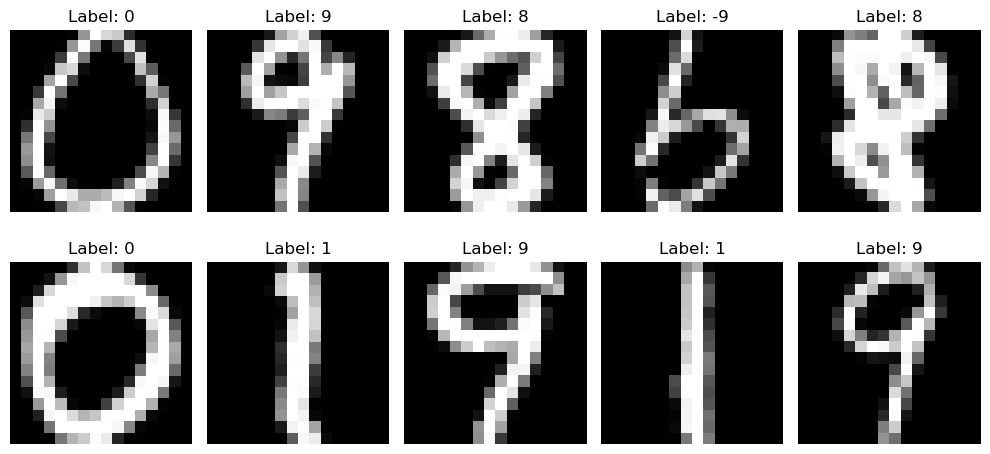

In [4]:
# Separate the label (first column) and the image pixels (remaining columns)
labels = MNIST.iloc[:, 0].astype(int).values
images = MNIST.iloc[:, 1:].values

img_dim = int(np.sqrt(images.shape[1]))
# Plot some images (for example, the first 10)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    # Reshape the flat image into 16x16
    img = images[i].reshape(img_dim, img_dim)
    # Show the image. Using cmap='gray' for better visualization.
    ax.imshow(img, cmap='gray', interpolation='nearest')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [23]:
catdog = pd.read_csv('catdogdata.txt', sep=' ').values

In [24]:
labels_cd = np.zeros(catdog.shape[0])
labels_cd[99:] = 1  # 0 for cats, 1 for dogs

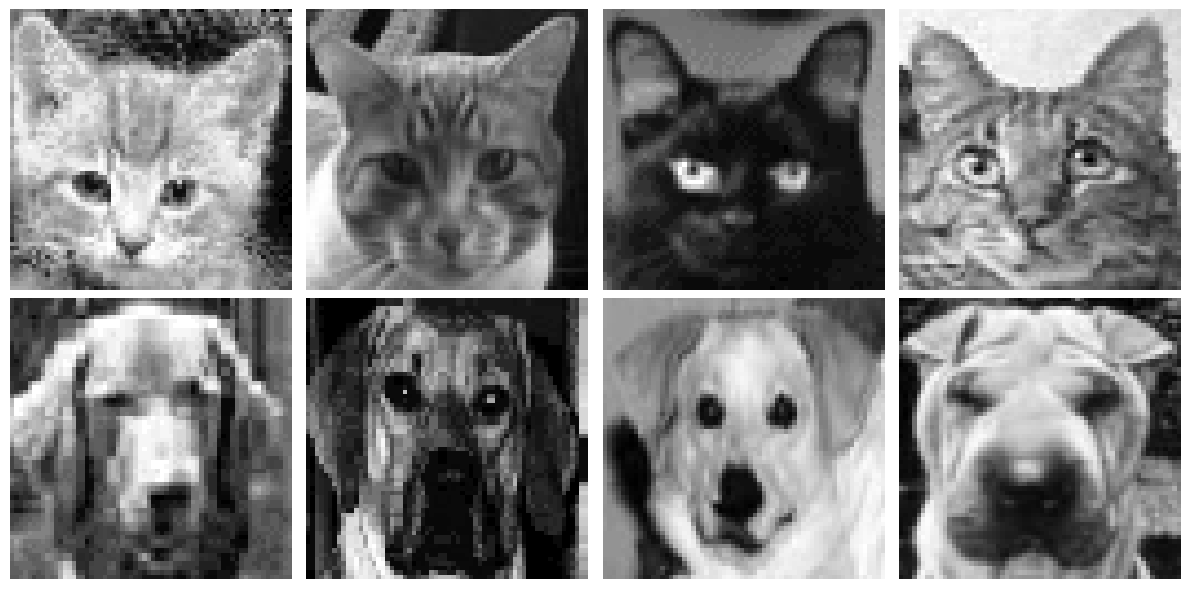

In [25]:
def rotateM(img):
   return np.rot90(img, k=-1)

np.random.seed(0)

ssc = np.random.choice(np.where(labels_cd == 0)[0], 4, replace=False)
ssd = np.random.choice(np.where(labels_cd == 1)[0], 4, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(12, 6))

for i , idx in enumerate([ssc[0], ssc[1], ssc[2], ssc[3], ssd[0], ssd[1], ssd[2], ssd[3]]):
   img = catdog[idx].reshape(64, 64)
   img = rotateM(img)
   ax = axs[i // 4, i % 4]
   ax.imshow(img, cmap='gray')
   ax.axis('off') 

plt.tight_layout()
plt.show()

In [28]:
labels_cd.shape

(198,)

### Part 1

#### MNIST: F-test and Lasso


==================== RUN 1/3 ====================

=== ANOVA Feature Selection ===
k=50: CV Balanced Accuracy = 0.8525
k=100: CV Balanced Accuracy = 0.8979
k=150: CV Balanced Accuracy = 0.9071
k=200: CV Balanced Accuracy = 0.9097
k=250: CV Balanced Accuracy = 0.9116

=== Lasso Feature Selection ===

--- ANOVA Selected Features ---
Logistic Regression:
  Accuracy = 0.9100
  Balanced Accuracy = 0.8992
SVM:
  Accuracy = 0.9000
  Balanced Accuracy = 0.8898
Random Forest:
  Accuracy = 0.9100
  Balanced Accuracy = 0.9004

--- Lasso Selected Features ---
Logistic Regression:
  Accuracy = 0.9175
  Balanced Accuracy = 0.9078
SVM:
  Accuracy = 0.9100
  Balanced Accuracy = 0.9008
Random Forest:
  Accuracy = 0.9050
  Balanced Accuracy = 0.8946

==================== RUN 2/3 ====================

=== ANOVA Feature Selection ===
k=50: CV Balanced Accuracy = 0.8390
k=100: CV Balanced Accuracy = 0.8941
k=150: CV Balanced Accuracy = 0.9089
k=200: CV Balanced Accuracy = 0.9121
k=250: CV Balanced Accurac

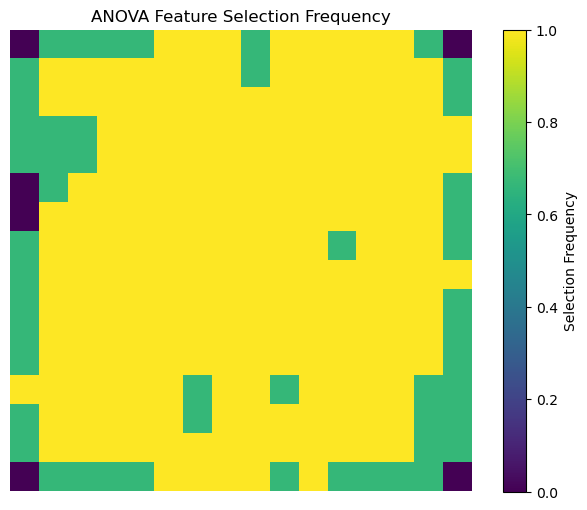

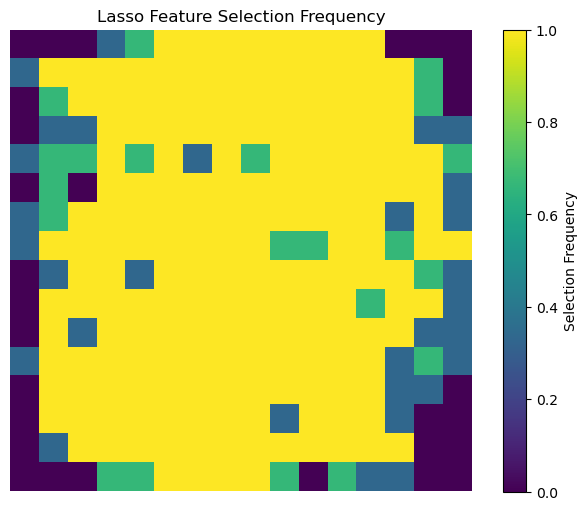

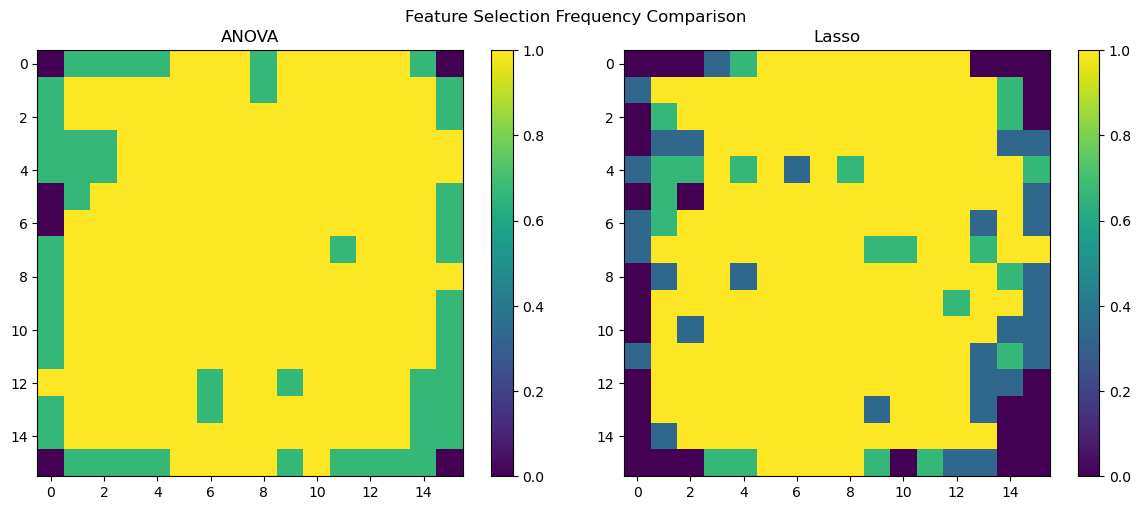


=== Performance Summary ===

Classifier: Logistic Regression

Method: ANOVA
  Avg best k: 233.3
  Accuracy: 0.9175 ± 0.0089
  Balanced Accuracy: 0.9071 ± 0.0098

Method: Lasso
  Avg best C: 1.0276
  Avg features: 200.0
  Accuracy: 0.9158 ± 0.0082
  Balanced Accuracy: 0.9051 ± 0.0094

Classifier: SVM

Method: ANOVA
  Avg best k: 233.3
  Accuracy: 0.9092 ± 0.0072
  Balanced Accuracy: 0.8988 ± 0.0075

Method: Lasso
  Avg best C: 1.0276
  Avg features: 200.0
  Accuracy: 0.9100 ± 0.0061
  Balanced Accuracy: 0.9001 ± 0.0081

Classifier: Random Forest

Method: ANOVA
  Avg best k: 233.3
  Accuracy: 0.9225 ± 0.0089
  Balanced Accuracy: 0.9138 ± 0.0095

Method: Lasso
  Avg best C: 1.0276
  Avg features: 200.0
  Accuracy: 0.9267 ± 0.0159
  Balanced Accuracy: 0.9179 ± 0.0170


In [ ]:
# --- Configuration ---
N_RUNS = 3                   # Number of experimental runs
K_VALUES = [50, 100, 150, 200, 250]    # Values of k to test for ANOVA
TEST_SIZE = 0.2              # Test set size
IMG_SHAPE = (16, 16)         # Assuming 16x16 images (256 features)

# --- Classifiers ---
classifiers = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=200),
    "SVM": LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# --- Feature Selection Frequency Tracking ---
feature_selection_freq = {
    'ANOVA': np.zeros(IMG_SHAPE[0] * IMG_SHAPE[1]),  # Global tracking
    'Lasso': np.zeros(IMG_SHAPE[0] * IMG_SHAPE[1])
}

# --- Classifier Performance Results ---
results = defaultdict(lambda: {
    'ANOVA': {
        'best_k': [],
        'test_accuracies': [],
        'test_balanced_accuracy': []
    },
    'Lasso': {
        'best_C': [],
        'num_features': [],
        'test_accuracies': [],
        'test_balanced_accuracy': []
    }
})

# --- Main Experiment ---
for run in range(N_RUNS):
    print(f"\n{'='*20} RUN {run+1}/{N_RUNS} {'='*20}")
    random_state = run * 42
    
    # Data splitting
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=TEST_SIZE, 
        random_state=random_state, stratify=labels)
    
    # Feature scaling
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # === ANOVA Feature Selection ===
    print("\n=== ANOVA Feature Selection ===")
    cv_scores = []
    for k in K_VALUES:
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        
        # Evaluate k using simple classifier
        temp_clf = LogisticRegression(solver='liblinear', max_iter=200)
        scores = []
        for train_idx, val_idx in cv.split(X_train_selected, y_train):
            temp_clf.fit(X_train_selected[train_idx], y_train[train_idx])
            scores.append(balanced_accuracy_score(
                y_train[val_idx], 
                temp_clf.predict(X_train_selected[val_idx])
            ))
        cv_scores.append(np.mean(scores))
        print(f"k={k}: CV Balanced Accuracy = {np.mean(scores):.4f}")
    
    best_k = K_VALUES[np.argmax(cv_scores)]
    selector = SelectKBest(score_func=f_classif, k=best_k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    selected_indices = selector.get_support(indices=True)
    
    # Update ANOVA feature frequency globally
    feature_selection_freq['ANOVA'][selected_indices] += 1/N_RUNS
    
    # === Lasso Feature Selection ===
    print("\n=== Lasso Feature Selection ===")
    lasso_pipeline = Pipeline([
        ('classifier', LogisticRegression(
            penalty='l1', solver='liblinear', 
            max_iter=200, random_state=random_state))
    ])
    grid_search = GridSearchCV(
        lasso_pipeline, 
        {'classifier__C': np.logspace(-3, 1, 7)}, 
        cv=cv, 
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    best_C = grid_search.best_params_['classifier__C']
    best_lasso = grid_search.best_estimator_.named_steps['classifier']
    selected_indices = np.where(np.abs(best_lasso.coef_).sum(axis=0) > 1e-6)[0]
    num_selected = len(selected_indices)
    
    # Update Lasso feature frequency globally
    feature_selection_freq['Lasso'][selected_indices] += 1/N_RUNS
    
    # === Classifier Evaluation ===
    for method in ['ANOVA', 'Lasso']:
        print(f"\n--- {method} Selected Features ---")
        if method == 'ANOVA':
            X_train_sel = X_train_selected
            X_test_sel = X_test_selected
        else:
            X_train_sel = X_train[:, selected_indices]
            X_test_sel = X_test[:, selected_indices]
        
        for clf_name, clf in classifiers.items():
            clf.fit(X_train_sel, y_train)
            y_pred = clf.predict(X_test_sel)
            
            results[clf_name][method]['test_accuracies'].append(
                accuracy_score(y_test, y_pred))
            results[clf_name][method]['test_balanced_accuracy'].append(
                balanced_accuracy_score(y_test, y_pred))
            
            if method == 'ANOVA':
                results[clf_name][method]['best_k'].append(best_k)
            else:
                results[clf_name][method]['best_C'].append(best_C)
                results[clf_name][method]['num_features'].append(num_selected)
            
            print(f"{clf_name}:")
            print(f"  Accuracy = {accuracy_score(y_test, y_pred):.4f}")
            print(f"  Balanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.4f}")

# === Visualizations ===
def plot_feature_heatmap(freq_array, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(freq_array.reshape(IMG_SHAPE), 
               cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Selection Frequency')
    plt.title(title)
    plt.axis('off')
    plt.show()

print("\n=== Feature Selection Heatmaps ===")
plot_feature_heatmap(feature_selection_freq['ANOVA'], "ANOVA Feature Selection Frequency")
plot_feature_heatmap(feature_selection_freq['Lasso'], "Lasso Feature Selection Frequency")

# Side-by-side comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(feature_selection_freq['ANOVA'].reshape(IMG_SHAPE),
           cmap='viridis', interpolation='nearest')
plt.title("ANOVA")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(feature_selection_freq['Lasso'].reshape(IMG_SHAPE),
           cmap='viridis', interpolation='nearest')
plt.title("Lasso")
plt.colorbar()
plt.suptitle("Feature Selection Frequency Comparison")
plt.tight_layout()
plt.show()

# === Performance Summary ===
print("\n=== Performance Summary ===")
for clf_name in classifiers:
    print(f"\nClassifier: {clf_name}")
    for method in ['ANOVA', 'Lasso']:
        print(f"\nMethod: {method}")
        if method == 'ANOVA':
            print(f"  Avg best k: {np.mean(results[clf_name][method]['best_k']):.1f}")
        else:
            print(f"  Avg best C: {np.mean(results[clf_name][method]['best_C']):.4f}")
            print(f"  Avg features: {np.mean(results[clf_name][method]['num_features']):.1f}")
        
        print(f"  Accuracy: {np.mean(results[clf_name][method]['test_accuracies']):.4f} ± {np.std(results[clf_name][method]['test_accuracies']):.4f}")
        print(f"  Balanced Accuracy: {np.mean(results[clf_name][method]['test_balanced_accuracy']):.4f} ± {np.std(results[clf_name][method]['test_balanced_accuracy']):.4f}")

#### CatDogs: F-test and Lasso


==================== RUN 1/3 ====================

=== ANOVA Feature Selection ===
k=1000: CV Balanced Accuracy = 0.7846
k=1500: CV Balanced Accuracy = 0.7971
k=2000: CV Balanced Accuracy = 0.8042
k=2500: CV Balanced Accuracy = 0.8167
k=3000: CV Balanced Accuracy = 0.8163
k=3500: CV Balanced Accuracy = 0.8038

=== Lasso Feature Selection ===

--- ANOVA Selected Features ---
Logistic Regression:
  Accuracy = 0.8750
  Balanced Accuracy = 0.8750
SVM:
  Accuracy = 0.8750
  Balanced Accuracy = 0.8750
Random Forest:
  Accuracy = 0.8250
  Balanced Accuracy = 0.8250

--- Lasso Selected Features ---
Logistic Regression:
  Accuracy = 0.8750
  Balanced Accuracy = 0.8750
SVM:
  Accuracy = 0.8750
  Balanced Accuracy = 0.8750
Random Forest:
  Accuracy = 0.9250
  Balanced Accuracy = 0.9250

==================== RUN 2/3 ====================

=== ANOVA Feature Selection ===
k=1000: CV Balanced Accuracy = 0.8350
k=1500: CV Balanced Accuracy = 0.8604
k=2000: CV Balanced Accuracy = 0.8350
k=2500: CV Bala

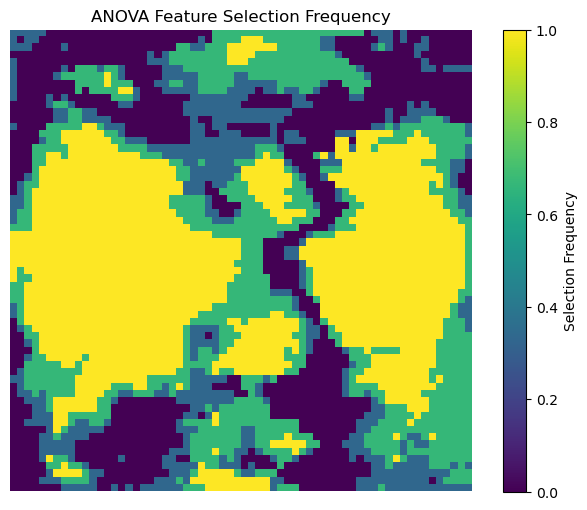

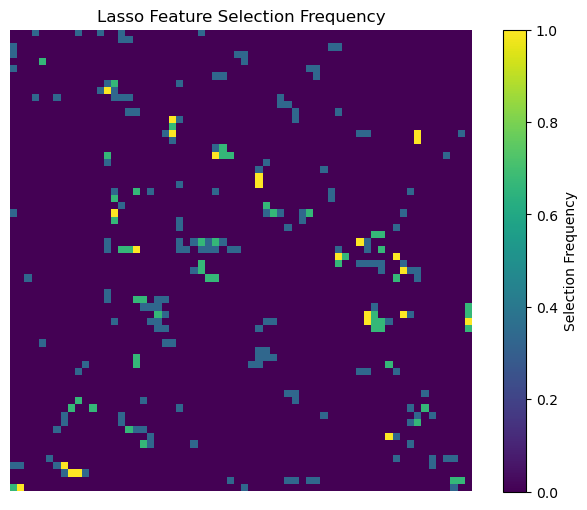

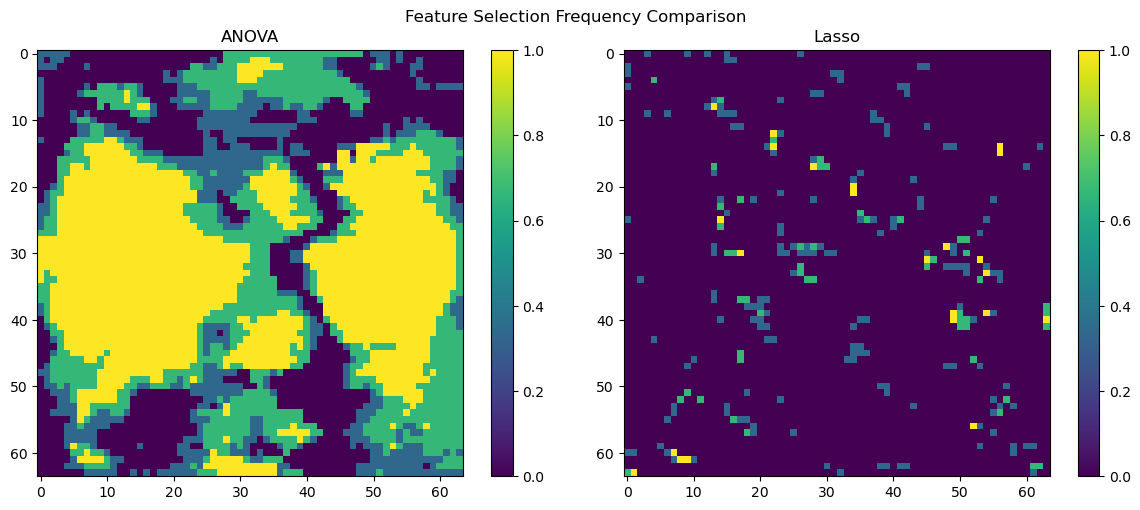


=== Performance Summary ===

Classifier: Logistic Regression

Method: ANOVA
  Avg best k: 2333.3
  Accuracy: 0.8500 ± 0.0204
  Balanced Accuracy: 0.8500 ± 0.0204

Method: Lasso
  Avg best C: 7.3848
  Avg features: 113.3
  Accuracy: 0.8250 ± 0.0408
  Balanced Accuracy: 0.8250 ± 0.0408

Classifier: SVM

Method: ANOVA
  Avg best k: 2333.3
  Accuracy: 0.8167 ± 0.0514
  Balanced Accuracy: 0.8167 ± 0.0514

Method: Lasso
  Avg best C: 7.3848
  Avg features: 113.3
  Accuracy: 0.8083 ± 0.0471
  Balanced Accuracy: 0.8083 ± 0.0471

Classifier: Random Forest

Method: ANOVA
  Avg best k: 2333.3
  Accuracy: 0.7833 ± 0.0425
  Balanced Accuracy: 0.7833 ± 0.0425

Method: Lasso
  Avg best C: 7.3848
  Avg features: 113.3
  Accuracy: 0.8000 ± 0.0890
  Balanced Accuracy: 0.8000 ± 0.0890


In [30]:
# --- Configuration ---
N_RUNS = 3                   # Number of experimental runs
K_VALUES = [1000, 1500, 2000, 2500, 3000, 3500]    # Values of k to test for ANOVA
TEST_SIZE = 0.2              # Test set size
IMG_SHAPE = (64, 64)         
# --- Classifiers ---
classifiers = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=200),
    "SVM": LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# --- Feature Selection Frequency Tracking ---
feature_selection_freq = {
    'ANOVA': np.zeros(IMG_SHAPE[0] * IMG_SHAPE[1]),  # Global tracking
    'Lasso': np.zeros(IMG_SHAPE[0] * IMG_SHAPE[1])
}

# --- Classifier Performance Results ---
results = defaultdict(lambda: {
    'ANOVA': {
        'best_k': [],
        'test_accuracies': [],
        'test_balanced_accuracy': []
    },
    'Lasso': {
        'best_C': [],
        'num_features': [],
        'test_accuracies': [],
        'test_balanced_accuracy': []
    }
})

# --- Main Experiment ---
for run in range(N_RUNS):
    print(f"\n{'='*20} RUN {run+1}/{N_RUNS} {'='*20}")
    random_state = run * 42
    
    # Data splitting
    X_train, X_test, y_train, y_test = train_test_split(
        catdog, labels_cd, test_size=TEST_SIZE, 
        random_state=random_state, stratify=labels_cd)
    
    # Feature scaling
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # === ANOVA Feature Selection ===
    print("\n=== ANOVA Feature Selection ===")
    cv_scores = []
    for k in K_VALUES:
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        
        # Evaluate k using simple classifier
        temp_clf = LogisticRegression(solver='liblinear', max_iter=200)
        scores = []
        for train_idx, val_idx in cv.split(X_train_selected, y_train):
            temp_clf.fit(X_train_selected[train_idx], y_train[train_idx])
            scores.append(balanced_accuracy_score(
                y_train[val_idx], 
                temp_clf.predict(X_train_selected[val_idx])
            ))
        cv_scores.append(np.mean(scores))
        print(f"k={k}: CV Balanced Accuracy = {np.mean(scores):.4f}")
    
    best_k = K_VALUES[np.argmax(cv_scores)]
    selector = SelectKBest(score_func=f_classif, k=best_k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    selected_indices = selector.get_support(indices=True)
    
    # Update ANOVA feature frequency globally
    feature_selection_freq['ANOVA'][selected_indices] += 1/N_RUNS
    
    # === Lasso Feature Selection ===
    print("\n=== Lasso Feature Selection ===")
    lasso_pipeline = Pipeline([
        ('classifier', LogisticRegression(
            penalty='l1', solver='liblinear', 
            max_iter=200, random_state=random_state))
    ])
    grid_search = GridSearchCV(
        lasso_pipeline, 
        {'classifier__C': np.logspace(-3, 1, 7)}, 
        cv=cv, 
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    best_C = grid_search.best_params_['classifier__C']
    best_lasso = grid_search.best_estimator_.named_steps['classifier']
    selected_indices = np.where(np.abs(best_lasso.coef_).sum(axis=0) > 1e-6)[0]
    num_selected = len(selected_indices)
    
    # Update Lasso feature frequency globally
    feature_selection_freq['Lasso'][selected_indices] += 1/N_RUNS
    
    # === Classifier Evaluation ===
    for method in ['ANOVA', 'Lasso']:
        print(f"\n--- {method} Selected Features ---")
        if method == 'ANOVA':
            X_train_sel = X_train_selected
            X_test_sel = X_test_selected
        else:
            X_train_sel = X_train[:, selected_indices]
            X_test_sel = X_test[:, selected_indices]
        
        for clf_name, clf in classifiers.items():
            clf.fit(X_train_sel, y_train)
            y_pred = clf.predict(X_test_sel)
            
            results[clf_name][method]['test_accuracies'].append(
                accuracy_score(y_test, y_pred))
            results[clf_name][method]['test_balanced_accuracy'].append(
                balanced_accuracy_score(y_test, y_pred))
            
            if method == 'ANOVA':
                results[clf_name][method]['best_k'].append(best_k)
            else:
                results[clf_name][method]['best_C'].append(best_C)
                results[clf_name][method]['num_features'].append(num_selected)
            
            print(f"{clf_name}:")
            print(f"  Accuracy = {accuracy_score(y_test, y_pred):.4f}")
            print(f"  Balanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.4f}")

# === Visualizations ===
def plot_feature_heatmap(freq_array, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(freq_array.reshape(IMG_SHAPE), 
               cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Selection Frequency')
    plt.title(title)
    plt.axis('off')
    plt.show()

print("\n=== Feature Selection Heatmaps ===")
plot_feature_heatmap(feature_selection_freq['ANOVA'], "ANOVA Feature Selection Frequency")
plot_feature_heatmap(feature_selection_freq['Lasso'], "Lasso Feature Selection Frequency")

# Side-by-side comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(feature_selection_freq['ANOVA'].reshape(IMG_SHAPE),
           cmap='viridis', interpolation='nearest')
plt.title("ANOVA")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(feature_selection_freq['Lasso'].reshape(IMG_SHAPE),
           cmap='viridis', interpolation='nearest')
plt.title("Lasso")
plt.colorbar()
plt.suptitle("Feature Selection Frequency Comparison")
plt.tight_layout()
plt.show()

# === Performance Summary ===
print("\n=== Performance Summary ===")
for clf_name in classifiers:
    print(f"\nClassifier: {clf_name}")
    for method in ['ANOVA', 'Lasso']:
        print(f"\nMethod: {method}")
        if method == 'ANOVA':
            print(f"  Avg best k: {np.mean(results[clf_name][method]['best_k']):.1f}")
        else:
            print(f"  Avg best C: {np.mean(results[clf_name][method]['best_C']):.4f}")
            print(f"  Avg features: {np.mean(results[clf_name][method]['num_features']):.1f}")
        
        print(f"  Accuracy: {np.mean(results[clf_name][method]['test_accuracies']):.4f} ± {np.std(results[clf_name][method]['test_accuracies']):.4f}")
        print(f"  Balanced Accuracy: {np.mean(results[clf_name][method]['test_balanced_accuracy']):.4f} ± {np.std(results[clf_name][method]['test_balanced_accuracy']):.4f}")

### Part 2: 80%, 50%, 20% sample size

#### MNIST


########################################
# EXPERIMENTING WITH 80% OF SAMPLES
########################################

==================== RUN 1/3 ====================

=== ANOVA Feature Selection ===
k=50: CV Balanced Accuracy = 0.8389
k=100: CV Balanced Accuracy = 0.8902
k=150: CV Balanced Accuracy = 0.9035
k=200: CV Balanced Accuracy = 0.9106
k=250: CV Balanced Accuracy = 0.9170

=== Lasso Feature Selection ===

--- ANOVA Selected Features ---
Logistic Regression:
  Accuracy = 0.9125
  Balanced Accuracy = 0.9003
SVM:
  Accuracy = 0.9062
  Balanced Accuracy = 0.8917
Random Forest:
  Accuracy = 0.9281
  Balanced Accuracy = 0.9161

--- Lasso Selected Features ---
Logistic Regression:
  Accuracy = 0.9187
  Balanced Accuracy = 0.9072
SVM:
  Accuracy = 0.9125
  Balanced Accuracy = 0.8986
Random Forest:
  Accuracy = 0.9219
  Balanced Accuracy = 0.9100

==================== RUN 2/3 ====================

=== ANOVA Feature Selection ===
k=50: CV Balanced Accuracy = 0.8283
k=100: CV Balanced

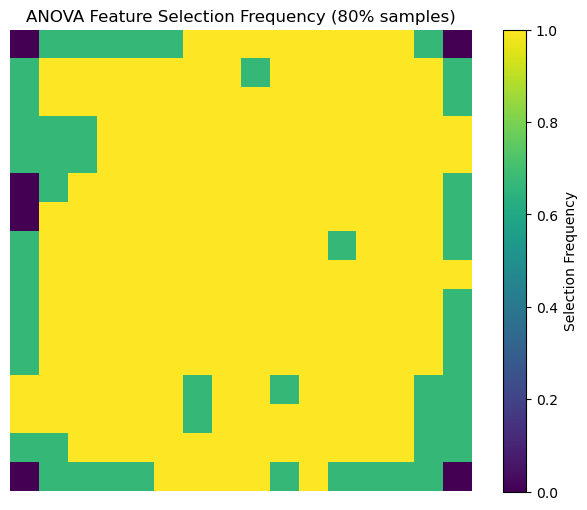

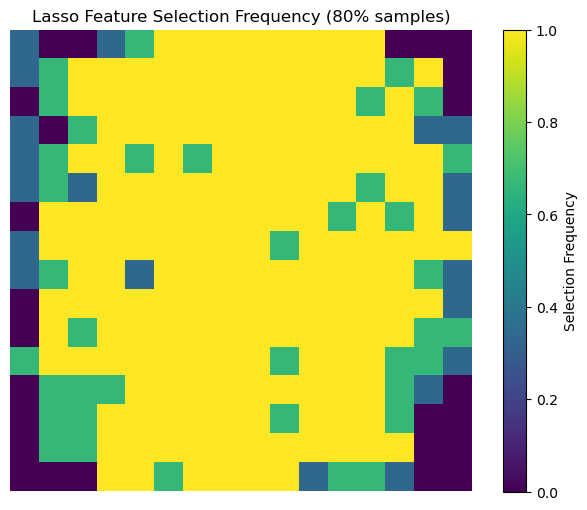

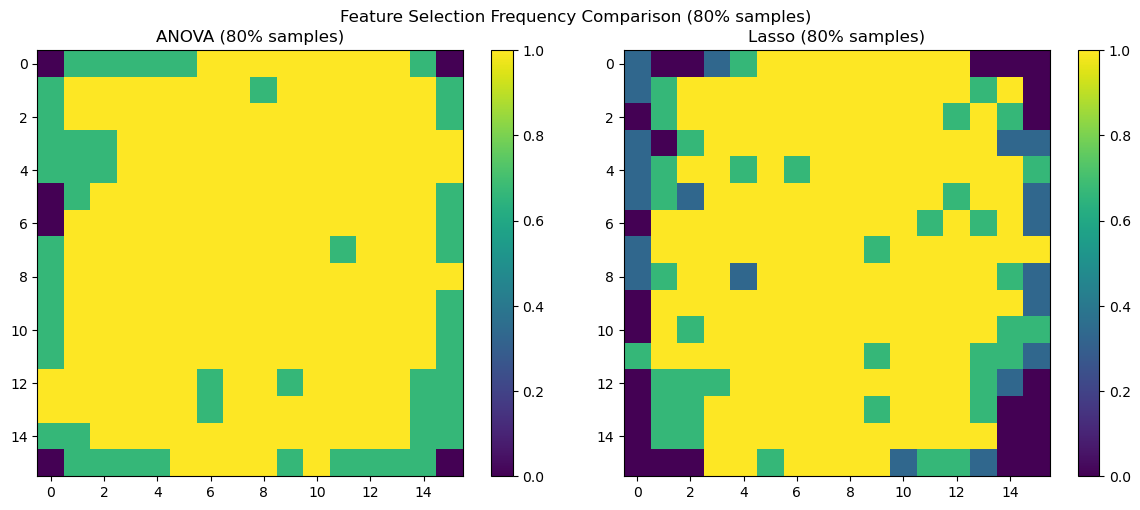


########################################
# EXPERIMENTING WITH 50% OF SAMPLES
########################################

==================== RUN 1/3 ====================

=== ANOVA Feature Selection ===
k=50: CV Balanced Accuracy = 0.8401
k=100: CV Balanced Accuracy = 0.8863
k=150: CV Balanced Accuracy = 0.8957
k=200: CV Balanced Accuracy = 0.9085
k=250: CV Balanced Accuracy = 0.9073

=== Lasso Feature Selection ===

--- ANOVA Selected Features ---
Logistic Regression:
  Accuracy = 0.8650
  Balanced Accuracy = 0.8458
SVM:
  Accuracy = 0.8500
  Balanced Accuracy = 0.8304
Random Forest:
  Accuracy = 0.8800
  Balanced Accuracy = 0.8604

--- Lasso Selected Features ---
Logistic Regression:
  Accuracy = 0.8650
  Balanced Accuracy = 0.8463
SVM:
  Accuracy = 0.8550
  Balanced Accuracy = 0.8368
Random Forest:
  Accuracy = 0.9000
  Balanced Accuracy = 0.8833

==================== RUN 2/3 ====================

=== ANOVA Feature Selection ===
k=50: CV Balanced Accuracy = 0.8099
k=100: CV Balanced

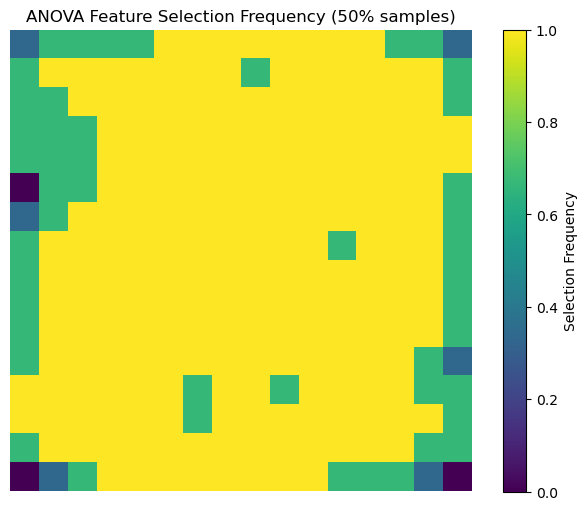

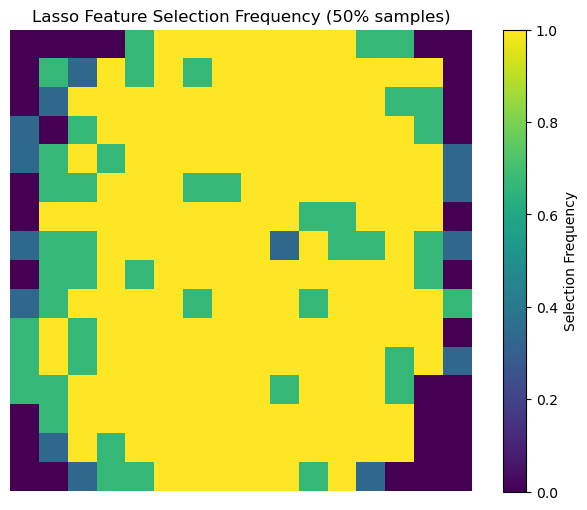

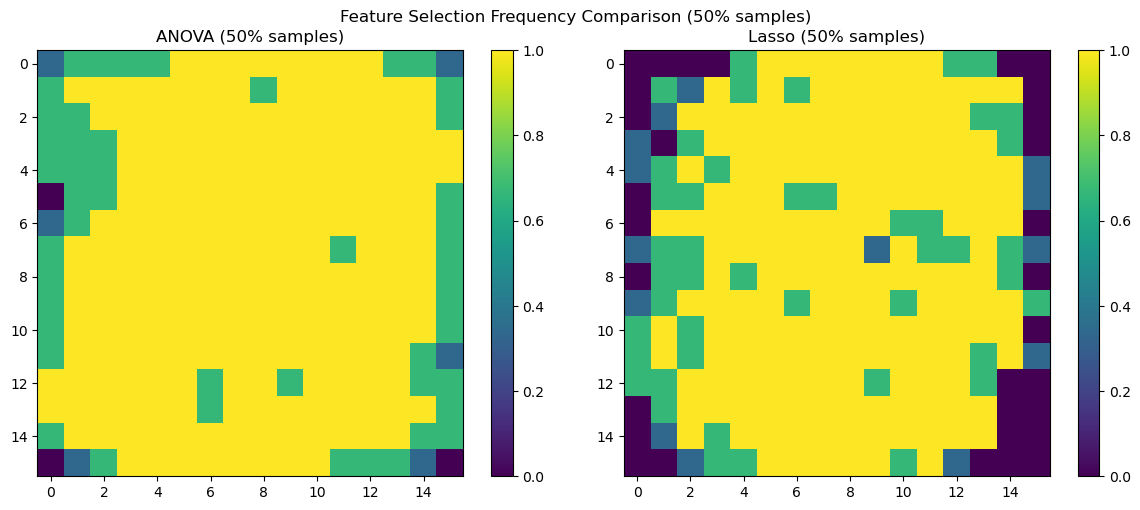


########################################
# EXPERIMENTING WITH 20% OF SAMPLES
########################################

==================== RUN 1/3 ====================

=== ANOVA Feature Selection ===
k=50: CV Balanced Accuracy = 0.8168
k=100: CV Balanced Accuracy = 0.8576
k=150: CV Balanced Accuracy = 0.8650
k=200: CV Balanced Accuracy = 0.8587
k=250: CV Balanced Accuracy = 0.8587

=== Lasso Feature Selection ===

--- ANOVA Selected Features ---
Logistic Regression:
  Accuracy = 0.8000
  Balanced Accuracy = 0.7903
SVM:
  Accuracy = 0.8000
  Balanced Accuracy = 0.7884
Random Forest:
  Accuracy = 0.8125
  Balanced Accuracy = 0.7948

--- Lasso Selected Features ---
Logistic Regression:
  Accuracy = 0.8000
  Balanced Accuracy = 0.7903
SVM:
  Accuracy = 0.7750
  Balanced Accuracy = 0.7646
Random Forest:
  Accuracy = 0.8125
  Balanced Accuracy = 0.7848

==================== RUN 2/3 ====================

=== ANOVA Feature Selection ===
k=50: CV Balanced Accuracy = 0.7832
k=100: CV Balanced

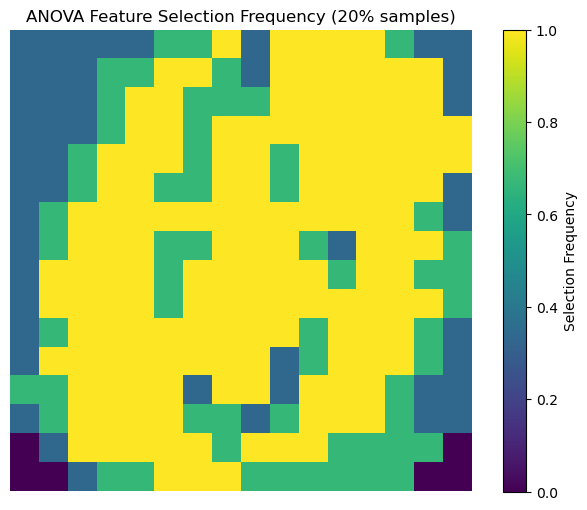

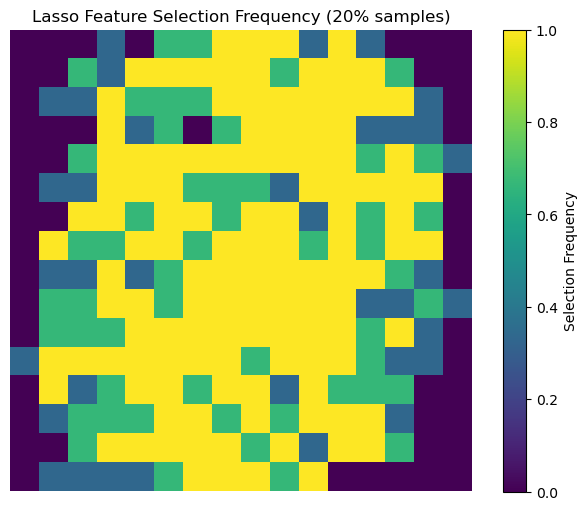

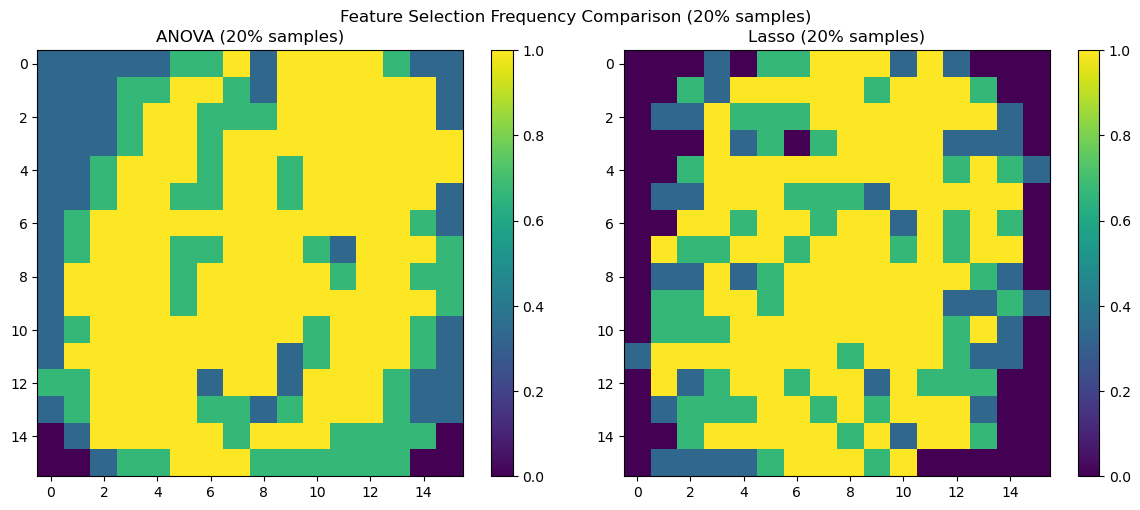


=== FINAL PERFORMANCE SUMMARY ACROSS SAMPLE SIZES ===

########################################
# RESULTS FOR 80% OF SAMPLES
########################################

Classifier: Logistic Regression

Method: ANOVA
  Avg best k: 233.3
  Accuracy: 0.9250 ± 0.0117
  Balanced Accuracy: 0.9168 ± 0.0135

Method: Lasso
  Avg best C: 1.5910
  Avg features: 205.0
  Accuracy: 0.9271 ± 0.0078
  Balanced Accuracy: 0.9193 ± 0.0093

Classifier: SVM

Method: ANOVA
  Avg best k: 233.3
  Accuracy: 0.9115 ± 0.0097
  Balanced Accuracy: 0.8992 ± 0.0092

Method: Lasso
  Avg best C: 1.5910
  Avg features: 205.0
  Accuracy: 0.9125 ± 0.0051
  Balanced Accuracy: 0.9002 ± 0.0034

Classifier: Random Forest

Method: ANOVA
  Avg best k: 233.3
  Accuracy: 0.9396 ± 0.0141
  Balanced Accuracy: 0.9316 ± 0.0148

Method: Lasso
  Avg best C: 1.5910
  Avg features: 205.0
  Accuracy: 0.9354 ± 0.0115
  Balanced Accuracy: 0.9275 ± 0.0133

########################################
# RESULTS FOR 50% OF SAMPLES
################

In [31]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
N_RUNS = 3                   # Number of experimental runs
K_VALUES = [50, 100, 150, 200, 250]    # Values of k to test for ANOVA
TEST_SIZE = 0.2              # Test set size
IMG_SHAPE = (16, 16)         # Assuming 16x16 images (256 features)
SAMPLE_SIZES = [0.8, 0.5, 0.2]  # Fractions of full dataset to test

# --- Classifiers ---
classifiers = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=200),
    "SVM": LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Dictionary to store all results
all_results = {}

for sample_size in SAMPLE_SIZES:
    print(f"\n{'#'*40}")
    print(f"# EXPERIMENTING WITH {sample_size*100:.0f}% OF SAMPLES")
    print(f"{'#'*40}")
    
    # --- Feature Selection Frequency Tracking ---
    feature_selection_freq = {
        'ANOVA': np.zeros(IMG_SHAPE[0] * IMG_SHAPE[1]),
        'Lasso': np.zeros(IMG_SHAPE[0] * IMG_SHAPE[1])
    }

    # --- Classifier Performance Results ---
    results = defaultdict(lambda: {
        'ANOVA': {
            'best_k': [],
            'test_accuracies': [],
            'test_balanced_accuracy': []
        },
        'Lasso': {
            'best_C': [],
            'num_features': [],
            'test_accuracies': [],
            'test_balanced_accuracy': []
        }
    })

    # --- Main Experiment ---
    for run in range(N_RUNS):
        print(f"\n{'='*20} RUN {run+1}/{N_RUNS} {'='*20}")
        random_state = run * 42
        
        # First split to get desired sample size
        X_sample, _, y_sample, _ = train_test_split(
            images, labels, 
            train_size=sample_size,
            random_state=random_state, 
            stratify=labels
        )
        
        # Then split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X_sample, y_sample, 
            test_size=TEST_SIZE, 
            random_state=random_state, 
            stratify=y_sample
        )
        
        # Feature scaling
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

        # === ANOVA Feature Selection ===
        print("\n=== ANOVA Feature Selection ===")
        cv_scores = []
        for k in K_VALUES:
            selector = SelectKBest(score_func=f_classif, k=k)
            X_train_selected = selector.fit_transform(X_train, y_train)
            
            # Evaluate k using simple classifier
            temp_clf = LogisticRegression(solver='liblinear', max_iter=200)
            scores = []
            for train_idx, val_idx in cv.split(X_train_selected, y_train):
                temp_clf.fit(X_train_selected[train_idx], y_train[train_idx])
                scores.append(balanced_accuracy_score(
                    y_train[val_idx], 
                    temp_clf.predict(X_train_selected[val_idx])
                ))
            cv_scores.append(np.mean(scores))
            print(f"k={k}: CV Balanced Accuracy = {np.mean(scores):.4f}")
        
        best_k = K_VALUES[np.argmax(cv_scores)]
        selector = SelectKBest(score_func=f_classif, k=best_k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)
        selected_indices = selector.get_support(indices=True)
        
        # Update ANOVA feature frequency globally
        feature_selection_freq['ANOVA'][selected_indices] += 1/N_RUNS
        
        # === Lasso Feature Selection ===
        print("\n=== Lasso Feature Selection ===")
        lasso_pipeline = Pipeline([
            ('classifier', LogisticRegression(
                penalty='l1', solver='liblinear', 
                max_iter=200, random_state=random_state))
        ])
        grid_search = GridSearchCV(
            lasso_pipeline, 
            {'classifier__C': np.logspace(-3, 1, 7)}, 
            cv=cv, 
            scoring='balanced_accuracy',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        best_C = grid_search.best_params_['classifier__C']
        best_lasso = grid_search.best_estimator_.named_steps['classifier']
        selected_indices = np.where(np.abs(best_lasso.coef_).sum(axis=0) > 1e-6)[0]
        num_selected = len(selected_indices)
        
        # Update Lasso feature frequency globally
        feature_selection_freq['Lasso'][selected_indices] += 1/N_RUNS
        
        # === Classifier Evaluation ===
        for method in ['ANOVA', 'Lasso']:
            print(f"\n--- {method} Selected Features ---")
            if method == 'ANOVA':
                X_train_sel = X_train_selected
                X_test_sel = X_test_selected
            else:
                X_train_sel = X_train[:, selected_indices]
                X_test_sel = X_test[:, selected_indices]
            
            for clf_name, clf in classifiers.items():
                clf.fit(X_train_sel, y_train)
                y_pred = clf.predict(X_test_sel)
                
                results[clf_name][method]['test_accuracies'].append(
                    accuracy_score(y_test, y_pred))
                results[clf_name][method]['test_balanced_accuracy'].append(
                    balanced_accuracy_score(y_test, y_pred))
                
                if method == 'ANOVA':
                    results[clf_name][method]['best_k'].append(best_k)
                else:
                    results[clf_name][method]['best_C'].append(best_C)
                    results[clf_name][method]['num_features'].append(num_selected)
                
                print(f"{clf_name}:")
                print(f"  Accuracy = {accuracy_score(y_test, y_pred):.4f}")
                print(f"  Balanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.4f}")

    # Store results for this sample size
    all_results[f"{sample_size*100:.0f}%"] = {
        'feature_selection_freq': feature_selection_freq,
        'classifier_results': results
    }

    # === Visualizations ===
    def plot_feature_heatmap(freq_array, title):
        plt.figure(figsize=(8, 6))
        plt.imshow(freq_array.reshape(IMG_SHAPE), 
                   cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Selection Frequency')
        plt.title(f"{title} ({sample_size*100:.0f}% samples)")
        plt.axis('off')
        plt.show()

    print("\n=== Feature Selection Heatmaps ===")
    plot_feature_heatmap(feature_selection_freq['ANOVA'], "ANOVA Feature Selection Frequency")
    plot_feature_heatmap(feature_selection_freq['Lasso'], "Lasso Feature Selection Frequency")

    # Side-by-side comparison
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(feature_selection_freq['ANOVA'].reshape(IMG_SHAPE),
               cmap='viridis', interpolation='nearest')
    plt.title(f"ANOVA ({sample_size*100:.0f}% samples)")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(feature_selection_freq['Lasso'].reshape(IMG_SHAPE),
               cmap='viridis', interpolation='nearest')
    plt.title(f"Lasso ({sample_size*100:.0f}% samples)")
    plt.colorbar()
    plt.suptitle(f"Feature Selection Frequency Comparison ({sample_size*100:.0f}% samples)")
    plt.tight_layout()
    plt.show()

# === Final Performance Summary ===
print("\n=== FINAL PERFORMANCE SUMMARY ACROSS SAMPLE SIZES ===")
for sample_size in SAMPLE_SIZES:
    print(f"\n{'#'*40}")
    print(f"# RESULTS FOR {sample_size*100:.0f}% OF SAMPLES")
    print(f"{'#'*40}")
    
    results = all_results[f"{sample_size*100:.0f}%"]['classifier_results']
    
    for clf_name in classifiers:
        print(f"\nClassifier: {clf_name}")
        for method in ['ANOVA', 'Lasso']:
            print(f"\nMethod: {method}")
            if method == 'ANOVA':
                print(f"  Avg best k: {np.mean(results[clf_name][method]['best_k']):.1f}")
            else:
                print(f"  Avg best C: {np.mean(results[clf_name][method]['best_C']):.4f}")
                print(f"  Avg features: {np.mean(results[clf_name][method]['num_features']):.1f}")
            
            print(f"  Accuracy: {np.mean(results[clf_name][method]['test_accuracies']):.4f} ± {np.std(results[clf_name][method]['test_accuracies']):.4f}")
            print(f"  Balanced Accuracy: {np.mean(results[clf_name][method]['test_balanced_accuracy']):.4f} ± {np.std(results[clf_name][method]['test_balanced_accuracy']):.4f}")

#### CatDogs


########################################
# EXPERIMENTING WITH 80% OF SAMPLES
########################################

==================== RUN 1/3 ====================

=== ANOVA Feature Selection ===
k=1000: CV Balanced Accuracy = 0.8186
k=1500: CV Balanced Accuracy = 0.8263
k=2000: CV Balanced Accuracy = 0.8115
k=2500: CV Balanced Accuracy = 0.8346
k=3000: CV Balanced Accuracy = 0.8346
k=3500: CV Balanced Accuracy = 0.8263

=== Lasso Feature Selection ===

--- ANOVA Selected Features ---
Logistic Regression:
  Accuracy = 0.8750
  Balanced Accuracy = 0.8750
SVM:
  Accuracy = 0.7500
  Balanced Accuracy = 0.7500
Random Forest:
  Accuracy = 0.7500
  Balanced Accuracy = 0.7500

--- Lasso Selected Features ---
Logistic Regression:
  Accuracy = 0.8125
  Balanced Accuracy = 0.8125
SVM:
  Accuracy = 0.7500
  Balanced Accuracy = 0.7500
Random Forest:
  Accuracy = 0.6875
  Balanced Accuracy = 0.6875

==================== RUN 2/3 ====================

=== ANOVA Feature Selection ===
k=1000: CV

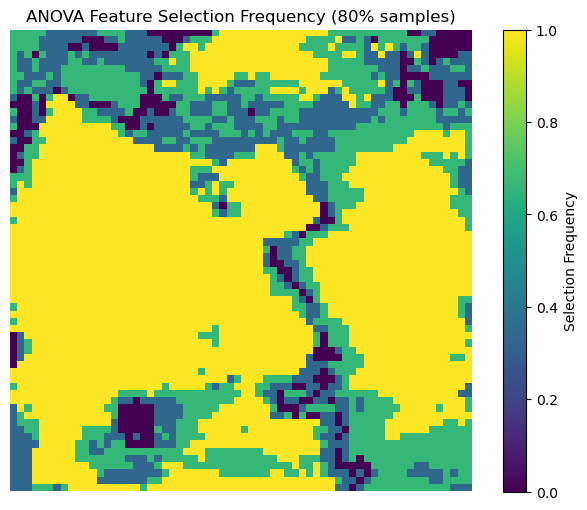

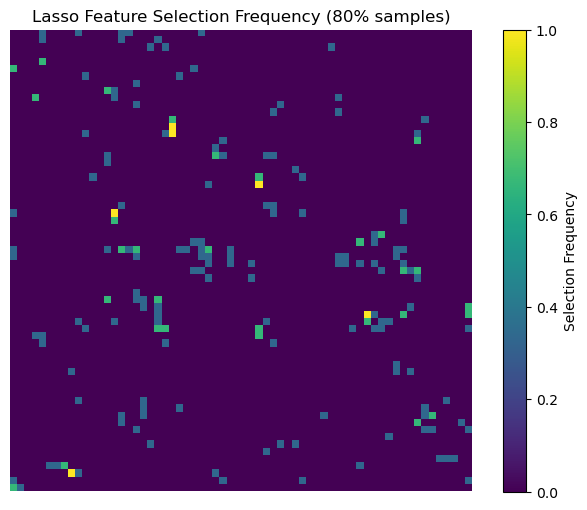

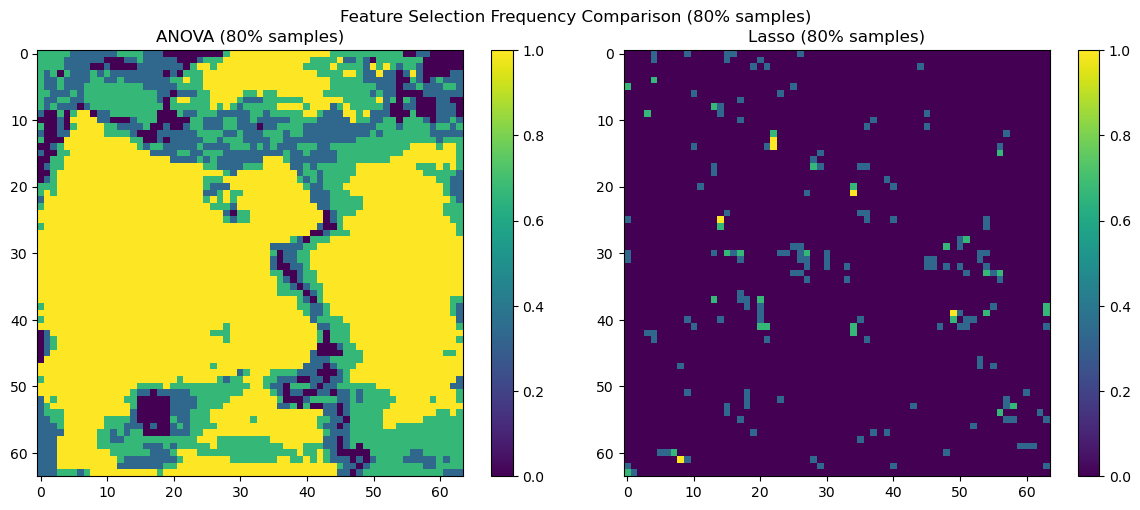


########################################
# EXPERIMENTING WITH 50% OF SAMPLES
########################################

==================== RUN 1/3 ====================

=== ANOVA Feature Selection ===
k=1000: CV Balanced Accuracy = 0.8982
k=1500: CV Balanced Accuracy = 0.8607
k=2000: CV Balanced Accuracy = 0.8482
k=2500: CV Balanced Accuracy = 0.8500
k=3000: CV Balanced Accuracy = 0.8625
k=3500: CV Balanced Accuracy = 0.8500

=== Lasso Feature Selection ===

--- ANOVA Selected Features ---
Logistic Regression:
  Accuracy = 0.7000
  Balanced Accuracy = 0.7000
SVM:
  Accuracy = 0.7000
  Balanced Accuracy = 0.7000
Random Forest:
  Accuracy = 0.6000
  Balanced Accuracy = 0.6000

--- Lasso Selected Features ---
Logistic Regression:
  Accuracy = 0.7500
  Balanced Accuracy = 0.7500
SVM:
  Accuracy = 0.7500
  Balanced Accuracy = 0.7500
Random Forest:
  Accuracy = 0.7000
  Balanced Accuracy = 0.7000

==================== RUN 2/3 ====================

=== ANOVA Feature Selection ===
k=1000: CV

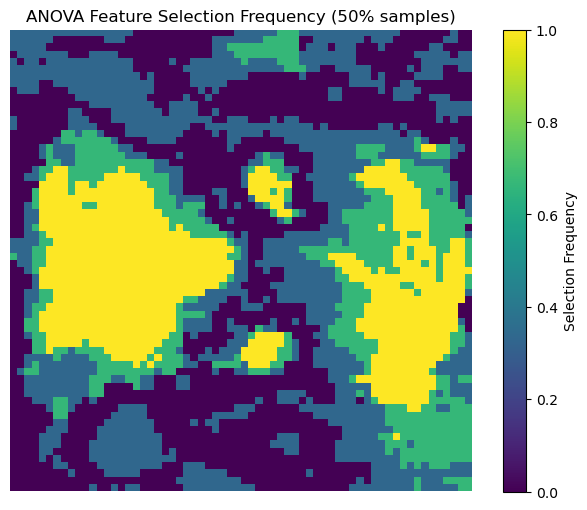

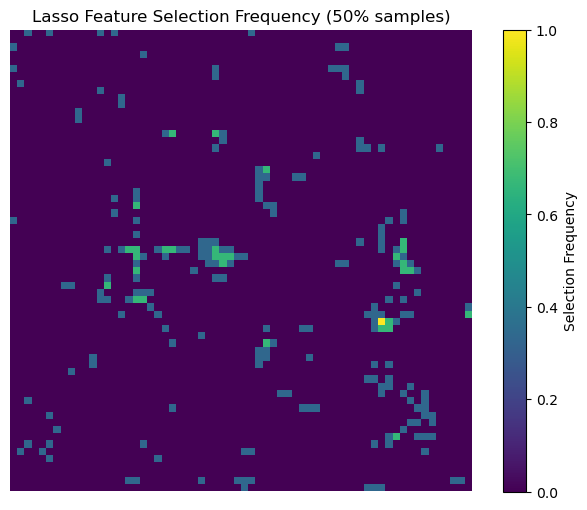

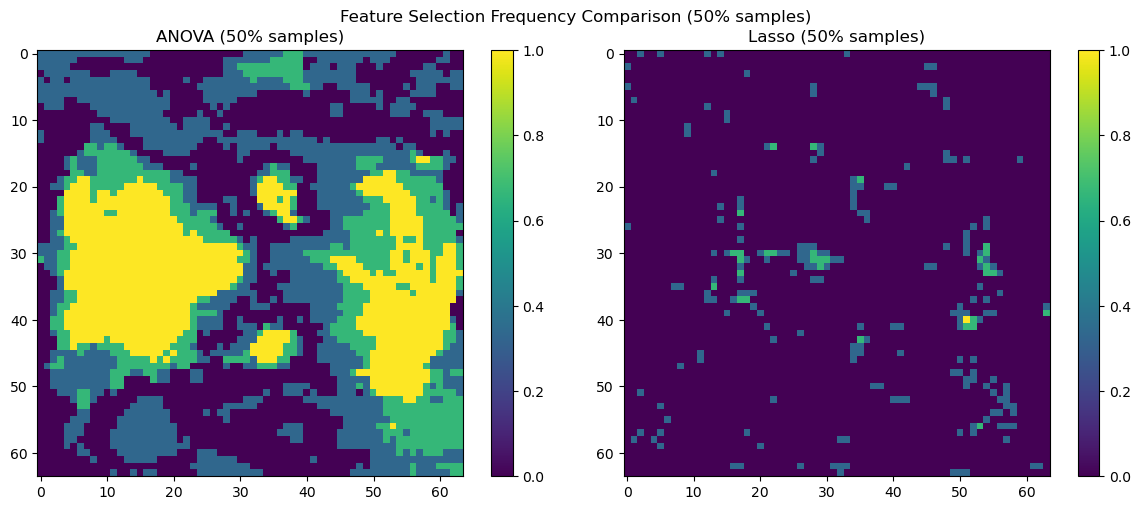


########################################
# EXPERIMENTING WITH 20% OF SAMPLES
########################################

==================== RUN 1/3 ====================

=== ANOVA Feature Selection ===
k=1000: CV Balanced Accuracy = 0.7750
k=1500: CV Balanced Accuracy = 0.7750
k=2000: CV Balanced Accuracy = 0.8083
k=2500: CV Balanced Accuracy = 0.8083
k=3000: CV Balanced Accuracy = 0.8083
k=3500: CV Balanced Accuracy = 0.8417

=== Lasso Feature Selection ===

--- ANOVA Selected Features ---
Logistic Regression:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000
SVM:
  Accuracy = 0.8750
  Balanced Accuracy = 0.8750
Random Forest:
  Accuracy = 1.0000
  Balanced Accuracy = 1.0000

--- Lasso Selected Features ---
Logistic Regression:
  Accuracy = 0.7500
  Balanced Accuracy = 0.7500
SVM:
  Accuracy = 0.7500
  Balanced Accuracy = 0.7500
Random Forest:
  Accuracy = 0.7500
  Balanced Accuracy = 0.7500

==================== RUN 2/3 ====================

=== ANOVA Feature Selection ===
k=1000: CV

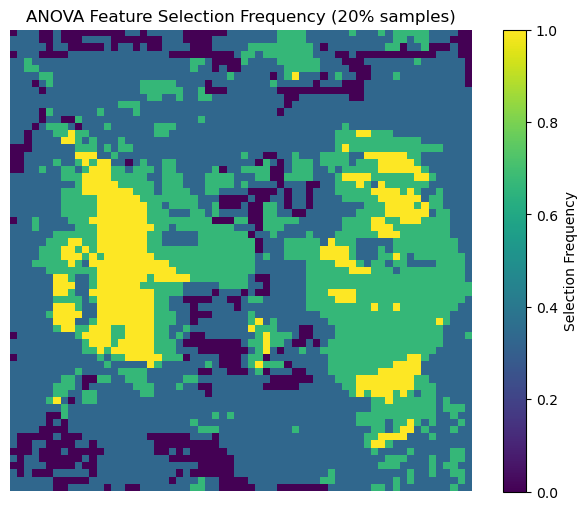

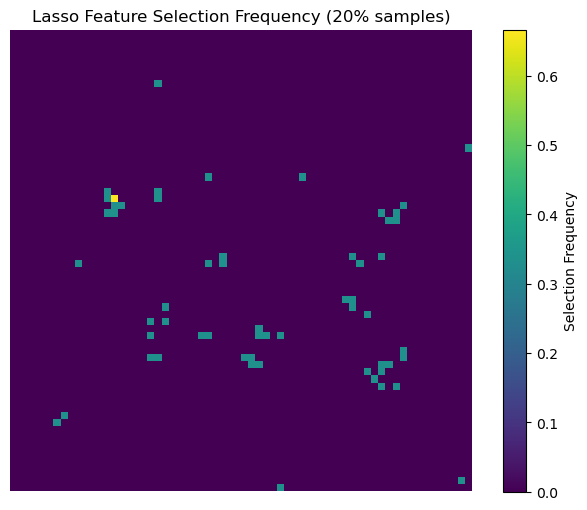

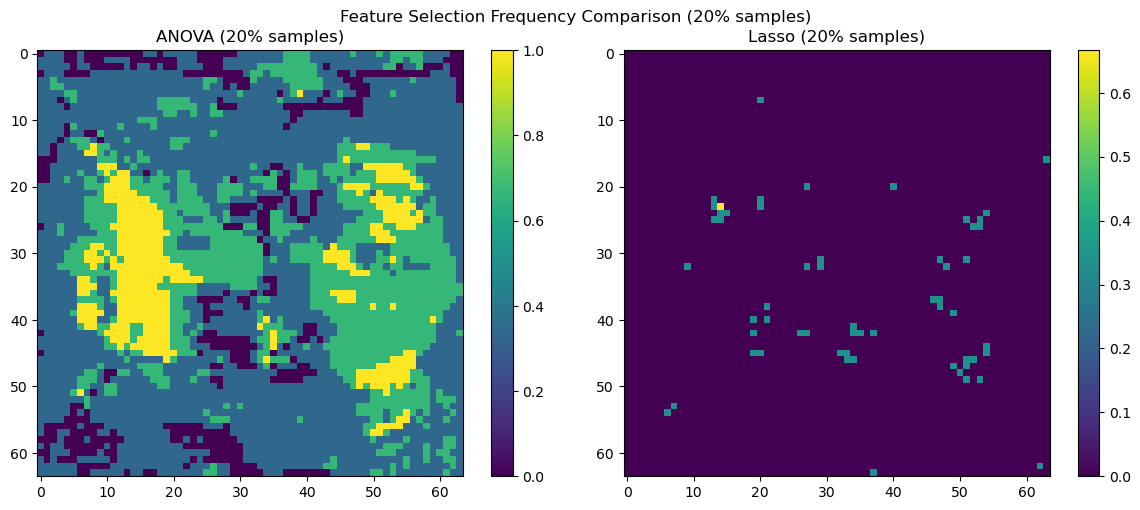


=== FINAL PERFORMANCE SUMMARY ACROSS SAMPLE SIZES ===

########################################
# RESULTS FOR 80% OF SAMPLES
########################################

Classifier: Logistic Regression

Method: ANOVA
  Avg best k: 3166.7
  Accuracy: 0.8542 ± 0.0531
  Balanced Accuracy: 0.8542 ± 0.0531

Method: Lasso
  Avg best C: 4.7696
  Avg features: 73.7
  Accuracy: 0.8229 ± 0.0390
  Balanced Accuracy: 0.8229 ± 0.0390

Classifier: SVM

Method: ANOVA
  Avg best k: 3166.7
  Accuracy: 0.7917 ± 0.0820
  Balanced Accuracy: 0.7917 ± 0.0820

Method: Lasso
  Avg best C: 4.7696
  Avg features: 73.7
  Accuracy: 0.8125 ± 0.0675
  Balanced Accuracy: 0.8125 ± 0.0675

Classifier: Random Forest

Method: ANOVA
  Avg best k: 3166.7
  Accuracy: 0.8021 ± 0.0531
  Balanced Accuracy: 0.8021 ± 0.0531

Method: Lasso
  Avg best C: 4.7696
  Avg features: 73.7
  Accuracy: 0.7708 ± 0.0780
  Balanced Accuracy: 0.7708 ± 0.0780

########################################
# RESULTS FOR 50% OF SAMPLES
################

In [32]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
N_RUNS = 3                   # Number of experimental runs
K_VALUES = [1000, 1500, 2000, 2500, 3000, 3500]     # Values of k to test for ANOVA
TEST_SIZE = 0.2              # Test set size
IMG_SHAPE = (64, 64)         # Assuming 16x16 images (256 features)
SAMPLE_SIZES = [0.8, 0.5, 0.2]  # Fractions of full dataset to test

# --- Classifiers ---
classifiers = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=200),
    "SVM": LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Dictionary to store all results
all_results = {}

for sample_size in SAMPLE_SIZES:
    print(f"\n{'#'*40}")
    print(f"# EXPERIMENTING WITH {sample_size*100:.0f}% OF SAMPLES")
    print(f"{'#'*40}")
    
    # --- Feature Selection Frequency Tracking ---
    feature_selection_freq = {
        'ANOVA': np.zeros(IMG_SHAPE[0] * IMG_SHAPE[1]),
        'Lasso': np.zeros(IMG_SHAPE[0] * IMG_SHAPE[1])
    }

    # --- Classifier Performance Results ---
    results = defaultdict(lambda: {
        'ANOVA': {
            'best_k': [],
            'test_accuracies': [],
            'test_balanced_accuracy': []
        },
        'Lasso': {
            'best_C': [],
            'num_features': [],
            'test_accuracies': [],
            'test_balanced_accuracy': []
        }
    })

    # --- Main Experiment ---
    for run in range(N_RUNS):
        print(f"\n{'='*20} RUN {run+1}/{N_RUNS} {'='*20}")
        random_state = run * 42
        
        # First split to get desired sample size
        X_sample, _, y_sample, _ = train_test_split(
            catdog, labels_cd, 
            train_size=sample_size,
            random_state=random_state, 
            stratify=labels_cd
        )
        
        # Then split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X_sample, y_sample, 
            test_size=TEST_SIZE, 
            random_state=random_state, 
            stratify=y_sample
        )
        
        # Feature scaling
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

        # === ANOVA Feature Selection ===
        print("\n=== ANOVA Feature Selection ===")
        cv_scores = []
        for k in K_VALUES:
            selector = SelectKBest(score_func=f_classif, k=k)
            X_train_selected = selector.fit_transform(X_train, y_train)
            
            # Evaluate k using simple classifier
            temp_clf = LogisticRegression(solver='liblinear', max_iter=200)
            scores = []
            for train_idx, val_idx in cv.split(X_train_selected, y_train):
                temp_clf.fit(X_train_selected[train_idx], y_train[train_idx])
                scores.append(balanced_accuracy_score(
                    y_train[val_idx], 
                    temp_clf.predict(X_train_selected[val_idx])
                ))
            cv_scores.append(np.mean(scores))
            print(f"k={k}: CV Balanced Accuracy = {np.mean(scores):.4f}")
        
        best_k = K_VALUES[np.argmax(cv_scores)]
        selector = SelectKBest(score_func=f_classif, k=best_k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)
        selected_indices = selector.get_support(indices=True)
        
        # Update ANOVA feature frequency globally
        feature_selection_freq['ANOVA'][selected_indices] += 1/N_RUNS
        
        # === Lasso Feature Selection ===
        print("\n=== Lasso Feature Selection ===")
        lasso_pipeline = Pipeline([
            ('classifier', LogisticRegression(
                penalty='l1', solver='liblinear', 
                max_iter=200, random_state=random_state))
        ])
        grid_search = GridSearchCV(
            lasso_pipeline, 
            {'classifier__C': np.logspace(-3, 1, 7)}, 
            cv=cv, 
            scoring='balanced_accuracy',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        best_C = grid_search.best_params_['classifier__C']
        best_lasso = grid_search.best_estimator_.named_steps['classifier']
        selected_indices = np.where(np.abs(best_lasso.coef_).sum(axis=0) > 1e-6)[0]
        num_selected = len(selected_indices)
        
        # Update Lasso feature frequency globally
        feature_selection_freq['Lasso'][selected_indices] += 1/N_RUNS
        
        # === Classifier Evaluation ===
        for method in ['ANOVA', 'Lasso']:
            print(f"\n--- {method} Selected Features ---")
            if method == 'ANOVA':
                X_train_sel = X_train_selected
                X_test_sel = X_test_selected
            else:
                X_train_sel = X_train[:, selected_indices]
                X_test_sel = X_test[:, selected_indices]
            
            for clf_name, clf in classifiers.items():
                clf.fit(X_train_sel, y_train)
                y_pred = clf.predict(X_test_sel)
                
                results[clf_name][method]['test_accuracies'].append(
                    accuracy_score(y_test, y_pred))
                results[clf_name][method]['test_balanced_accuracy'].append(
                    balanced_accuracy_score(y_test, y_pred))
                
                if method == 'ANOVA':
                    results[clf_name][method]['best_k'].append(best_k)
                else:
                    results[clf_name][method]['best_C'].append(best_C)
                    results[clf_name][method]['num_features'].append(num_selected)
                
                print(f"{clf_name}:")
                print(f"  Accuracy = {accuracy_score(y_test, y_pred):.4f}")
                print(f"  Balanced Accuracy = {balanced_accuracy_score(y_test, y_pred):.4f}")

    # Store results for this sample size
    all_results[f"{sample_size*100:.0f}%"] = {
        'feature_selection_freq': feature_selection_freq,
        'classifier_results': results
    }

    # === Visualizations ===
    def plot_feature_heatmap(freq_array, title):
        plt.figure(figsize=(8, 6))
        plt.imshow(freq_array.reshape(IMG_SHAPE), 
                   cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Selection Frequency')
        plt.title(f"{title} ({sample_size*100:.0f}% samples)")
        plt.axis('off')
        plt.show()

    print("\n=== Feature Selection Heatmaps ===")
    plot_feature_heatmap(feature_selection_freq['ANOVA'], "ANOVA Feature Selection Frequency")
    plot_feature_heatmap(feature_selection_freq['Lasso'], "Lasso Feature Selection Frequency")

    # Side-by-side comparison
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(feature_selection_freq['ANOVA'].reshape(IMG_SHAPE),
               cmap='viridis', interpolation='nearest')
    plt.title(f"ANOVA ({sample_size*100:.0f}% samples)")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(feature_selection_freq['Lasso'].reshape(IMG_SHAPE),
               cmap='viridis', interpolation='nearest')
    plt.title(f"Lasso ({sample_size*100:.0f}% samples)")
    plt.colorbar()
    plt.suptitle(f"Feature Selection Frequency Comparison ({sample_size*100:.0f}% samples)")
    plt.tight_layout()
    plt.show()

# === Final Performance Summary ===
print("\n=== FINAL PERFORMANCE SUMMARY ACROSS SAMPLE SIZES ===")
for sample_size in SAMPLE_SIZES:
    print(f"\n{'#'*40}")
    print(f"# RESULTS FOR {sample_size*100:.0f}% OF SAMPLES")
    print(f"{'#'*40}")
    
    results = all_results[f"{sample_size*100:.0f}%"]['classifier_results']
    
    for clf_name in classifiers:
        print(f"\nClassifier: {clf_name}")
        for method in ['ANOVA', 'Lasso']:
            print(f"\nMethod: {method}")
            if method == 'ANOVA':
                print(f"  Avg best k: {np.mean(results[clf_name][method]['best_k']):.1f}")
            else:
                print(f"  Avg best C: {np.mean(results[clf_name][method]['best_C']):.4f}")
                print(f"  Avg features: {np.mean(results[clf_name][method]['num_features']):.1f}")
            
            print(f"  Accuracy: {np.mean(results[clf_name][method]['test_accuracies']):.4f} ± {np.std(results[clf_name][method]['test_accuracies']):.4f}")
            print(f"  Balanced Accuracy: {np.mean(results[clf_name][method]['test_balanced_accuracy']):.4f} ± {np.std(results[clf_name][method]['test_balanced_accuracy']):.4f}")